<h1>   Import Libraries & Load Data</h1>

In [55]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import zscore
import pprint
import copy


# Make plots look nice
sns.set(style="whitegrid")

# Load all CSV files from raw_data/
files = glob.glob("../raw_data/*.csv")
print(f"Found {len(files)} files:", files)

all_datasets = []
campus_map = {"Kigali": "KIG-25", "Huye": "HUY-26", "Musanze": "MUS-27"}

for file in files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    campus_name = filename.split("_")[0]
    dataset_type = filename.split("_")[1].split(".")[0]
    
    df["Source_Campus_File"] = filename
    df["Campus_Name"] = campus_name
    df["Campus_ID"] = campus_map.get(campus_name, "Unknown")
    df["Dataset_Type"] = dataset_type
    
    all_datasets.append(df)

print(f"Loaded {len(all_datasets)} datasets successfully!")

Found 9 files: ['../raw_data\\Huye_assessments.csv', '../raw_data\\Huye_courses.csv', '../raw_data\\Huye_students.csv', '../raw_data\\Kigali_assessments.csv', '../raw_data\\Kigali_courses.csv', '../raw_data\\Kigali_students.csv', '../raw_data\\Musanze_assessments.csv', '../raw_data\\Musanze_courses.csv', '../raw_data\\Musanze_students.csv']
Loaded 9 datasets successfully!


<h1>Missing Data Summary and  Visualization</h1

In [ ]:
#Missing Values Summary Table
# -----------------------------
print("== Missing Values Summary ==\n")

for df in all_datasets:
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    
    if total_missing > 0:
        print(f"{dataset_name} | {campus_name}:")
        print(missing_counts[missing_counts > 0])
        print(f"Total missing values: {total_missing}\n")
    else:
        print(f"{dataset_name} | {campus_name}: No missing values\n")

=== Missing Values Summary ===

assessments | Huye:
Mark               15
Attendance_Rate    10
dtype: int64
Total missing values: 25

courses | Huye: No missing values

students | Huye:
Gender    14
DOB       21
dtype: int64
Total missing values: 35

assessments | Kigali:
Mark               10
Attendance_Rate     9
dtype: int64
Total missing values: 19

courses | Kigali: No missing values

students | Kigali:
Gender    15
DOB       18
dtype: int64
Total missing values: 33

assessments | Musanze:
Mark               16
Attendance_Rate    10
dtype: int64
Total missing values: 26

courses | Musanze: No missing values

students | Musanze:
Gender    11
DOB       22
dtype: int64
Total missing values: 33



Visualization

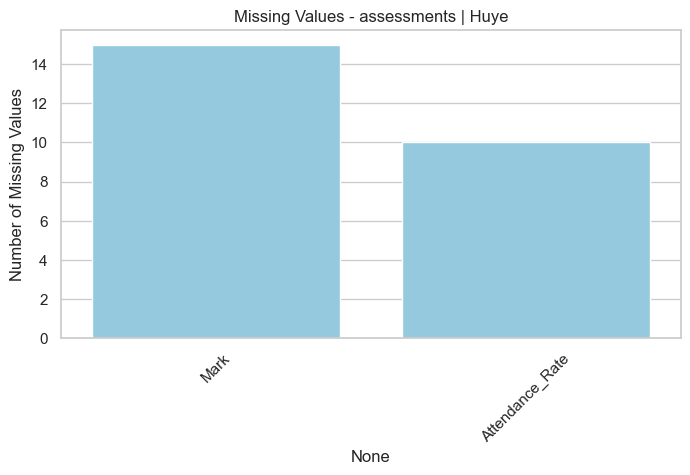

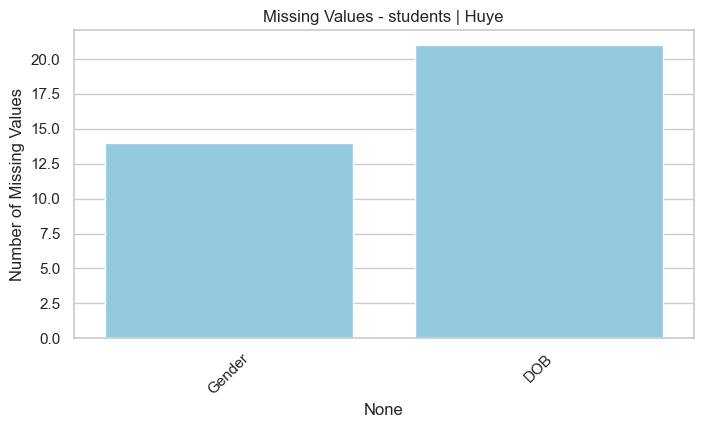

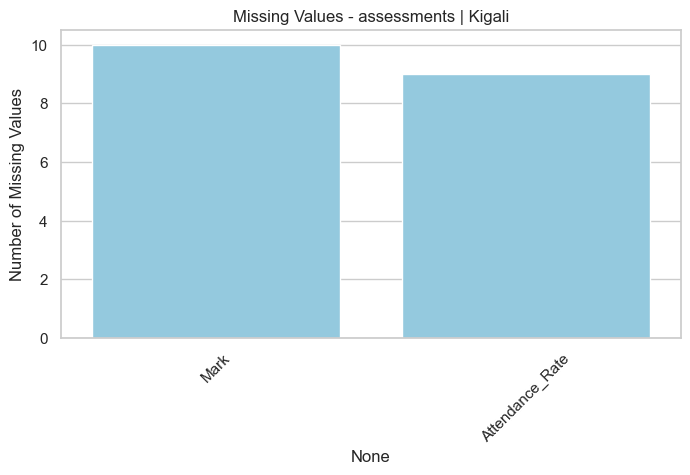

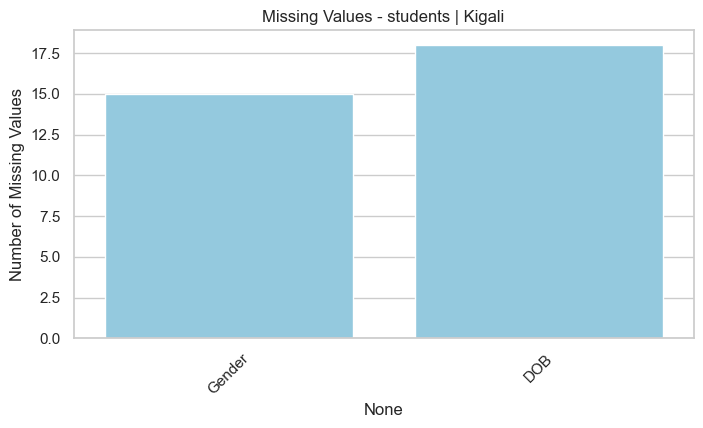

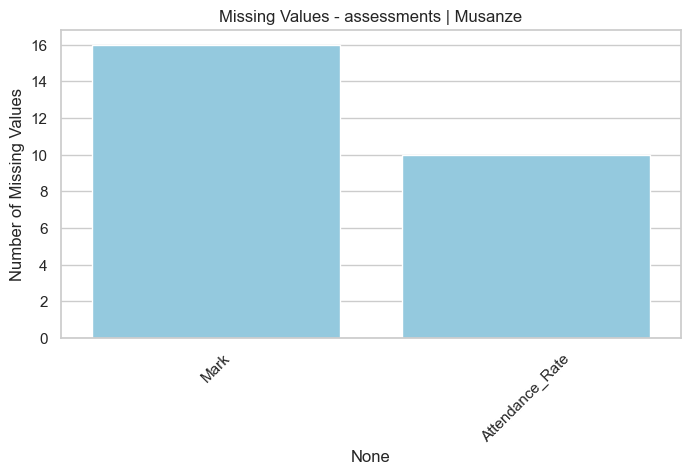

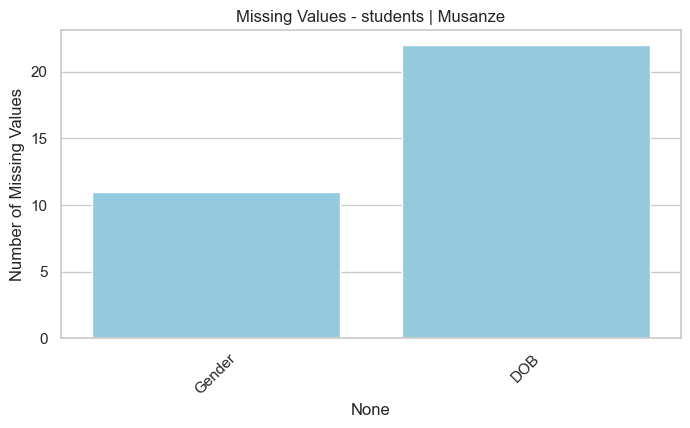

In [57]:
# Missing Data Visualization
# -----------------------------
for df in all_datasets:
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if not missing_counts.empty:
        plt.figure(figsize=(8,4))
        sns.barplot(
            x=missing_counts.index, 
            y=missing_counts.values, 
            color="skyblue",   
            dodge=False
        )
        plt.title(f"Missing Values - {dataset_name} | {campus_name}")
        plt.xticks(rotation=45)
        plt.ylabel("Number of Missing Values")
        plt.show()

In [ ]:
# Make a deep copy of original datasets for comparison
all_datasets_before = copy.deepcopy(all_datasets)  

<H1> Imputation </H1>

In [ ]:
# Impute All Missing Values (Mode & Median)
# -----------------------------
for df in all_datasets:
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    print(f"Imputing missing values for {dataset_name} | {campus_name}...")
    
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype("string")
    
    for col in df.columns:
        # Skip metadata columns
        if col in ['Source_Campus_File', 'Campus_Name', 'Campus_ID', 'Dataset_Type']:
            continue
        
        if df[col].isnull().sum() > 0:
            # Numeric columns → median
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].fillna(df[col].median())
            
            # Datetime columns → mode
            elif pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = df[col].fillna(df[col].mode()[0])
            
            # Object/categorical columns → mode
            elif pd.api.types.is_string_dtype(df[col]):
                df[col] = df[col].fillna(df[col].mode()[0])
    
print("All missing values imputed successfully!\n")

Imputing missing values for assessments | Huye...
Imputing missing values for courses | Huye...
Imputing missing values for students | Huye...
Imputing missing values for assessments | Kigali...
Imputing missing values for courses | Kigali...
Imputing missing values for students | Kigali...
Imputing missing values for assessments | Musanze...
Imputing missing values for courses | Musanze...
Imputing missing values for students | Musanze...
All missing values imputed successfully!



C:\Users\PC\AppData\Local\Temp\ipykernel_1120\1379035870.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include='object').columns:
C:\Users\PC\AppData\Local\Temp\ipykernel_1120\1379035870.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migrat

Summary DataFrame

In [60]:
summary_list = []

for i in range(len(all_datasets)):
    df_before = all_datasets_before[i]
    df_after = all_datasets[i]
    
    dataset_name = df_after['Dataset_Type'].iloc[0]
    campus_name = df_after['Campus_Name'].iloc[0]
    
    summary_list.append({
        "Dataset": dataset_name,
        "Campus": campus_name,
        "Shape": df_after.shape,
        "Missing_Before": df_before.isnull().sum().sum(),
        "Missing_After": df_after.isnull().sum().sum()
    })

summary_df = pd.DataFrame(summary_list)
summary_df

,Dataset,Campus,Shape,Missing_Before,Missing_After
0,assessments,Huye,"(50, 12)",25,0
1,courses,Huye,"(4, 7)",0,0
2,students,Huye,"(41, 11)",35,0
3,assessments,Kigali,"(50, 12)",19,0
4,courses,Kigali,"(4, 7)",0,0
5,students,Kigali,"(41, 11)",33,0
6,assessments,Musanze,"(50, 12)",26,0
7,courses,Musanze,"(4, 7)",0,0
8,students,Musanze,"(41, 11)",33,0


<h1> Duplicates</h1>

In [ ]:
# -----------------------------
# Detect Duplicates
# -----------------------------
for df in all_datasets:
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    print(f"Checking duplicates for {dataset_name} | {campus_name}...")
    
    if dataset_name == "students":
        # Check duplicates by Student_ID
        duplicate_rows = df[df.duplicated(subset=['Student_ID'], keep=False)]
        print(f"Duplicates by Student_ID: {len(duplicate_rows)}")
    
    elif dataset_name == "assessments":
        # Check duplicates by Student_ID, Course_Code, Academic_Year, Semester
        duplicate_rows = df[df.duplicated(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'], keep=False)]
        print(f"Duplicates by Student_ID + Course_Code + Academic_Year + Semester: {len(duplicate_rows)}")
    
    else:
        print("No duplicate check needed for courses dataset.")# Because in creating this dataset , there were no duplicates
    
    print("-" * 60)

Checking duplicates for assessments | Huye...
Duplicates by Student_ID + Course_Code + Academic_Year + Semester: 10
------------------------------------------------------------
Checking duplicates for courses | Huye...
No duplicate check needed for courses dataset.
------------------------------------------------------------
Checking duplicates for students | Huye...
Duplicates by Student_ID: 2
------------------------------------------------------------
Checking duplicates for assessments | Kigali...
Duplicates by Student_ID + Course_Code + Academic_Year + Semester: 4
------------------------------------------------------------
Checking duplicates for courses | Kigali...
No duplicate check needed for courses dataset.
------------------------------------------------------------
Checking duplicates for students | Kigali...
Duplicates by Student_ID: 2
------------------------------------------------------------
Checking duplicates for assessments | Musanze...
Duplicates by Student_ID + C

Removing duplicates and showing Before and After summary

In [ ]:
# Make a deep copy for before/after comparison
# -----------------------------
all_datasets_before_dup = copy.deepcopy(all_datasets_before)

# Detect and remove duplicates (Keep latest)

dedup_report = []

for i, df in enumerate(all_datasets_before):
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    # Count duplicates before removal
    if dataset_name == "students":
        dup_before = df.duplicated(subset=['Student_ID'], keep=False).sum()
        df = df.drop_duplicates(subset=['Student_ID'], keep='last').reset_index(drop=True)
    elif dataset_name == "assessments":
        dup_before = df.duplicated(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'], keep=False).sum()
        df = df.drop_duplicates(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'], keep='last').reset_index(drop=True)
    else:
        dup_before = 0  # courses dataset
    
    # Count duplicates after removal
    if dataset_name == "students":
        dup_after = df.duplicated(subset=['Student_ID'], keep=False).sum()
    elif dataset_name == "assessments":
        dup_after = df.duplicated(subset=['Student_ID', 'Course_Code', 'Academic_Year', 'Semester'], keep=False).sum()
    else:
        dup_after = 0
    
    # Add to report
    dedup_report.append({
        "Dataset": dataset_name,
        "Campus": campus_name,
        "Duplicates_Before": dup_before,
        "Duplicates_After": dup_after,
        "Rows_Removed": dup_before - dup_after
    })
    
    # Update the dataset
    all_datasets[i] = df

# Convert report to DataFrame
dedup_report_df = pd.DataFrame(dedup_report)

# Display the report
dedup_report_df

,Dataset,Campus,Duplicates_Before,Duplicates_After,Rows_Removed
0,assessments,Huye,10,0,10
1,courses,Huye,0,0,0
2,students,Huye,2,0,2
3,assessments,Kigali,4,0,4
4,courses,Kigali,0,0,0
5,students,Kigali,2,0,2
6,assessments,Musanze,0,0,0
7,courses,Musanze,0,0,0
8,students,Musanze,2,0,2


In [63]:

# Make a deep copy of cleaned datasets for comparison
all_datasets_before_outliers = copy.deepcopy(all_datasets)

<H1>3. OUTLIERS</H1>


assessments | Huye
Outlier counts per numeric column:
  Mark: 0
  Semester: 0
  Attendance_Rate: 0

courses | Huye
Outlier counts per numeric column:
  Credits: 0

students | Huye
Outlier counts per numeric column:
  Level: 0
  Intake_Year: 0

assessments | Kigali
Outlier counts per numeric column:
  Mark: 0
  Semester: 0
  Attendance_Rate: 0

courses | Kigali
Outlier counts per numeric column:
  Credits: 0

students | Kigali
Outlier counts per numeric column:
  Level: 0
  Intake_Year: 0

assessments | Musanze
Outlier counts per numeric column:
  Mark: 0
  Semester: 0
  Attendance_Rate: 0

courses | Musanze
Outlier counts per numeric column:
  Credits: 0

students | Musanze
Outlier counts per numeric column:
  Level: 0
  Intake_Year: 0


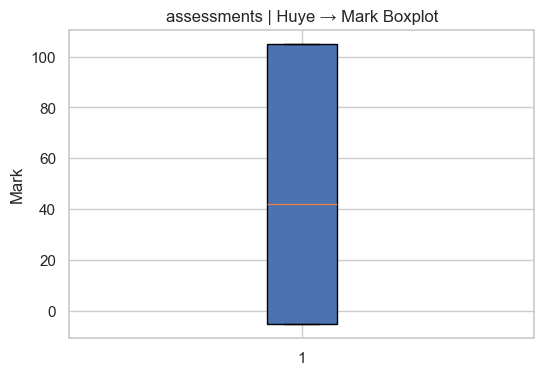

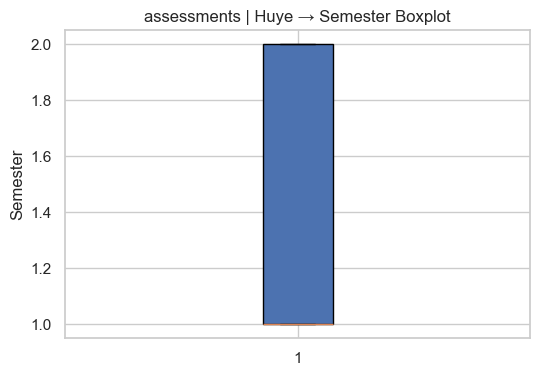

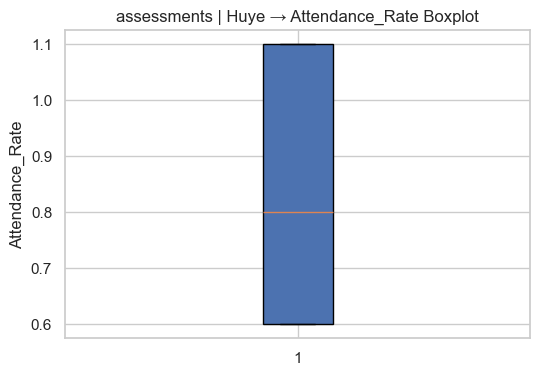

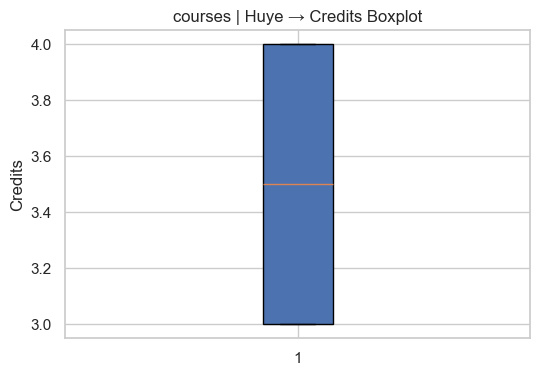

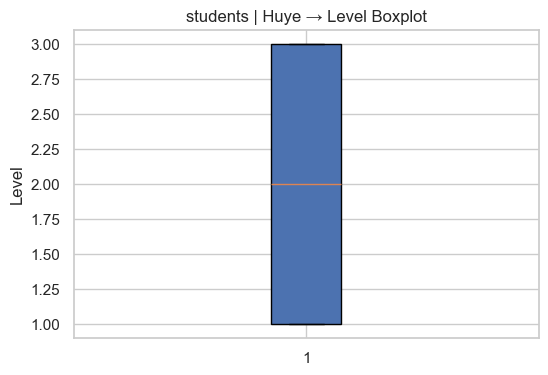

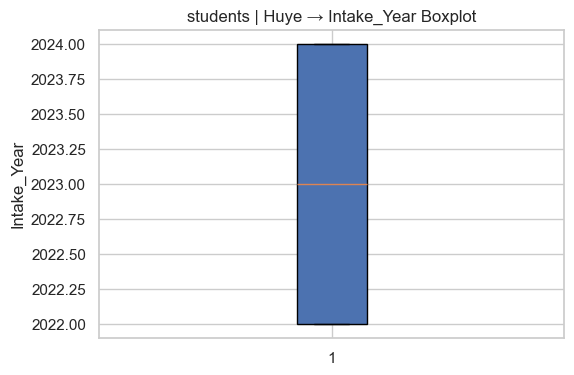

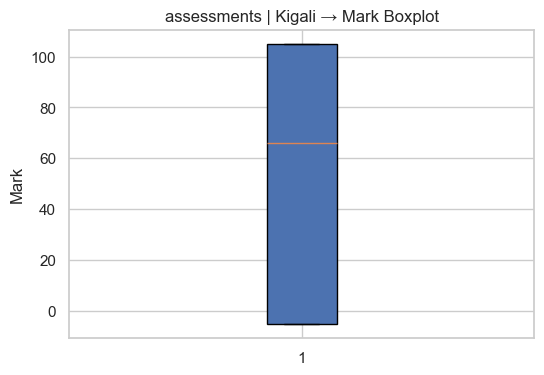

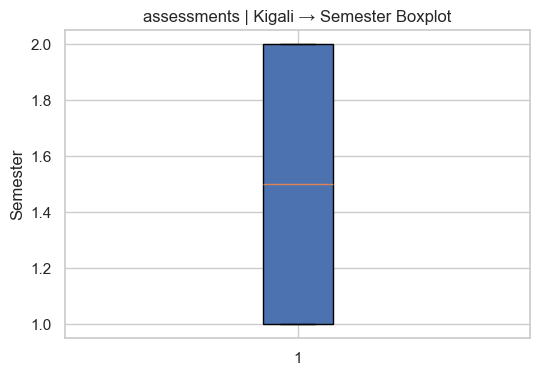

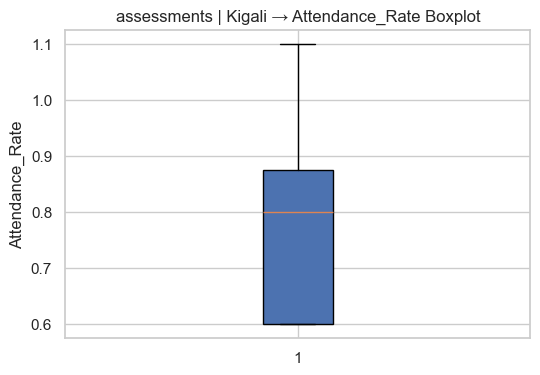

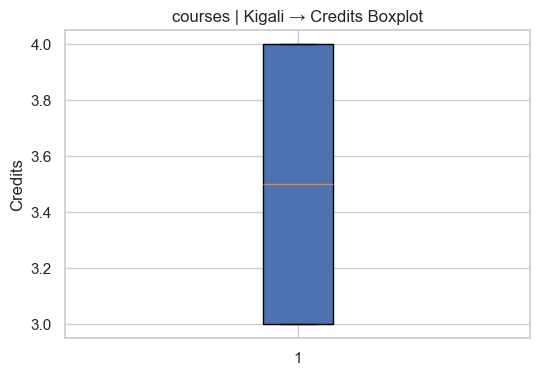

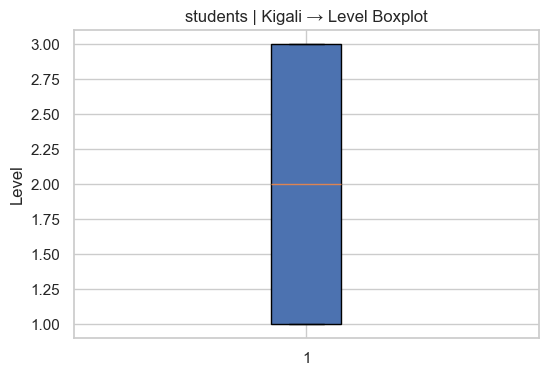

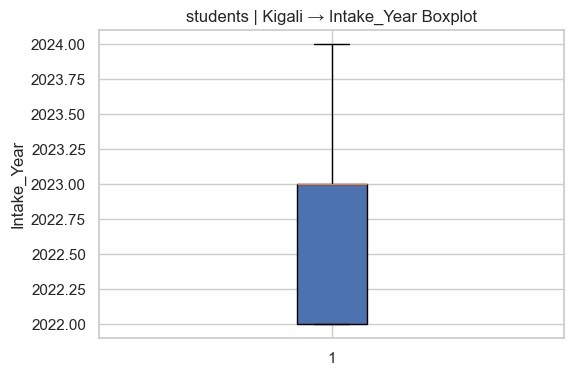

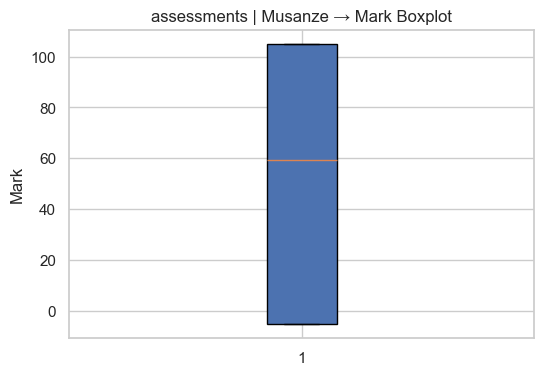

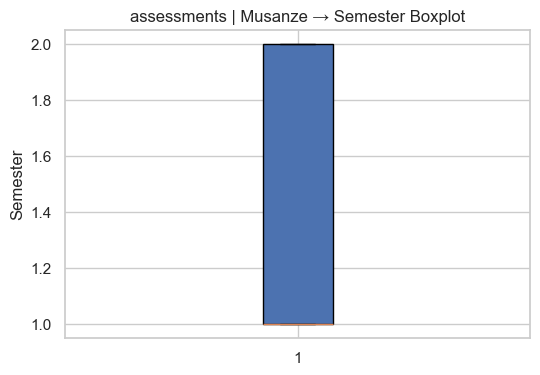

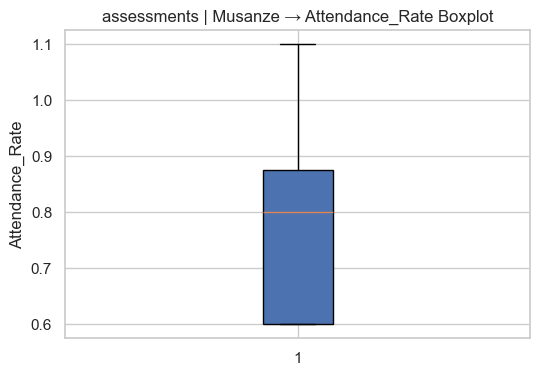

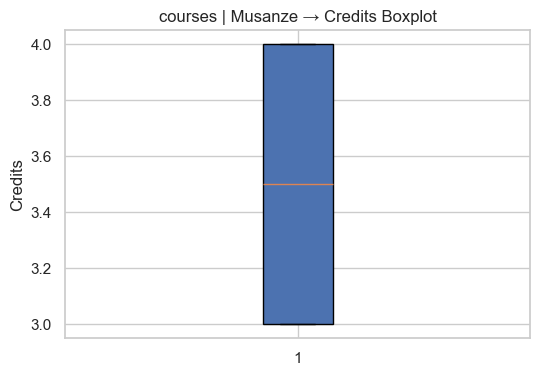

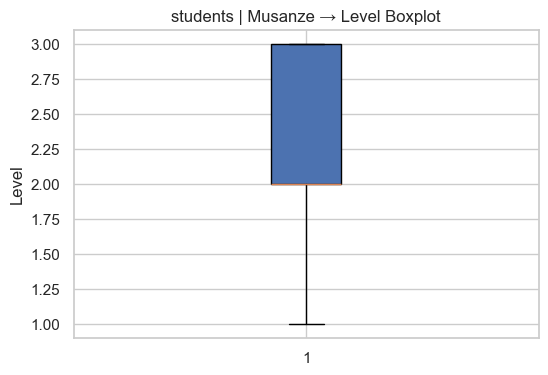

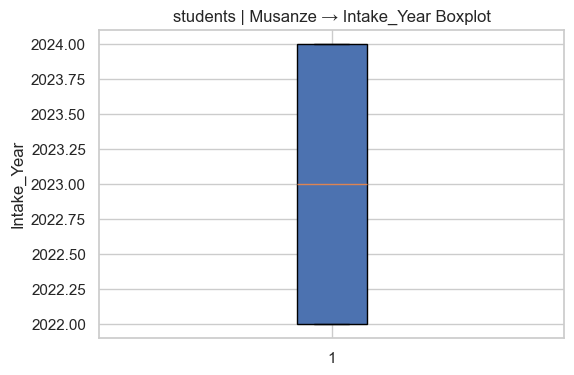

In [ ]:

# 1 Make a copy of raw datasets BEFORE cleaning
all_datasets_raw = copy.deepcopy(all_datasets)

# Set Z-score threshold
zscore_threshold = 3

# To store outlier info
outlier_reports = []

for df in all_datasets_raw:
    dataset_name = df['Dataset_Type'].iloc[0]
    campus_name = df['Campus_Name'].iloc[0]
    
    numeric_cols = df.select_dtypes(include='number').columns
    outlier_counts = {}
    
    # add outlier flag columns
    for col in numeric_cols:
        if df[col].nunique() > 1:
            z_scores = zscore(df[col], nan_policy='omit')
            is_outlier = (z_scores > zscore_threshold) | (z_scores < -zscore_threshold)
            
            # Save a column flag in the raw copy
            df[f'{col}_is_outlier'] = is_outlier
            
            # Count outliers
            outlier_counts[col] = is_outlier.sum()
        else:
            outlier_counts[col] = 0
    
    outlier_reports.append({
        "Dataset": dataset_name,
        "Campus": campus_name,
        "Outliers": outlier_counts,
        "DataFrame": df  # keep for plotting
    })

# 2 Display table of outliers
for report in outlier_reports:
    print(f"\n{report['Dataset']} | {report['Campus']}")
    print("Outlier counts per numeric column:")
    for col, count in report['Outliers'].items():
        print(f"  {col}: {count}")

# 3 Boxplots to visualize outliers
for report in outlier_reports:
    df = report['DataFrame']
    numeric_cols = df.select_dtypes(include='number').columns
    dataset_name = report['Dataset']
    campus_name = report['Campus']
    
    for col in numeric_cols:
        if df[col].nunique() > 1:
            plt.figure(figsize=(6,4))
            plt.boxplot(df[col].dropna(), vert=True, patch_artist=True)
            plt.title(f"{dataset_name} | {campus_name} → {col} Boxplot")
            plt.ylabel(col)
            plt.show()

In [65]:
# Treat Outliers
# -----------------------------
for i, df in enumerate(all_datasets):
    dataset_name = df['Dataset_Type'].iloc[0]
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        if df[col].nunique() > 1:
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - zscore_threshold * std
            upper_bound = mean + zscore_threshold * std
            
            # Cap outliers
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            
            # For Marks, also ensure 0-100
            if col == 'Mark':
                df[col] = df[col].apply(lambda x: x if 0 <= x <= 100 else None)
                # Impute NaN with course mean
                df['Mark'] = df.groupby('Course_Code')['Mark'].transform(lambda x: x.fillna(x.mean()))
    
    all_datasets[i] = df

In [66]:
for i, df in enumerate(all_datasets):
    dataset_type = df['Dataset_Type'].iloc[0]

    if dataset_type == "students":
        df = df.drop_duplicates(subset=['Student_ID'], keep='last')

    elif dataset_type == "assessments":
        df = df.drop_duplicates(
            subset=['Student_ID','Course_Code','Academic_Year','Semester'],
            keep='last'
        )

    all_datasets[i] = df.reset_index(drop=True)

print("Duplicates removed successfully.")

Duplicates removed successfully.


In [67]:
for i, df in enumerate(all_datasets):
    dataset_type = df['Dataset_Type'].iloc[0]

    # Only treat meaningful continuous columns
    candidate_cols = ['Mark', 'Attendance_Rate', 'Credits']
    numeric_cols = [c for c in candidate_cols if c in df.columns]

    for col in numeric_cols:
        if df[col].nunique() > 1:
            z_scores = zscore(df[col], nan_policy='omit')

            mean = df[col].mean()
            std = df[col].std()

            lower = mean - 3 * std
            upper = mean + 3 * std

            df[col] = df[col].clip(lower, upper)

            # Academic sanity check
            if col == 'Mark':
                df[col] = df[col].apply(
                    lambda x: x if 0 <= x <= 100 else np.nan
                )

    all_datasets[i] = df

print("Outliers treated.")

Outliers treated.


In [ ]:
print("Final imputation pass")

for i, df in enumerate(all_datasets):

    for col in df.columns:
        if col in ['Source_Campus_File','Campus_Name','Campus_ID','Dataset_Type']:
            continue

        if df[col].isnull().sum() > 0:

            # Numeric
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].fillna(df[col].median())

            # Dates
            elif "Date" in col or "DOB" in col:
                df[col] = df[col].fillna(df[col].mode()[0])

            # Categorical
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

    all_datasets[i] = df

print("Final imputation completed.")

Final imputation pass...
Final imputation completed.


In [69]:
print("\nFINAL DATA QUALITY CHECK\n")

for df in all_datasets:
    campus = df['Campus_Name'].iloc[0]
    dataset_type = df['Dataset_Type'].iloc[0]

    print("="*60)
    print(f"{dataset_type} | {campus}")

    print("Missing values:", df.isnull().sum().sum())
    print("Duplicate rows:", df.duplicated().sum())


FINAL DATA QUALITY CHECK

assessments | Huye
Missing values: 0
Duplicate rows: 0
courses | Huye
Missing values: 0
Duplicate rows: 0
students | Huye
Missing values: 0
Duplicate rows: 0
assessments | Kigali
Missing values: 0
Duplicate rows: 0
courses | Kigali
Missing values: 0
Duplicate rows: 0
students | Kigali
Missing values: 0
Duplicate rows: 0
assessments | Musanze
Missing values: 0
Duplicate rows: 0
courses | Musanze
Missing values: 0
Duplicate rows: 0
students | Musanze
Missing values: 0
Duplicate rows: 0


<h1> standardize formats</h1>

In [ ]:
print("Standardizing formats safely")

for i, df in enumerate(all_datasets):

    dataset_type = df['Dataset_Type'].iloc[0]
    campus = df['Campus_Name'].iloc[0]

    print(f"Cleaning formats → {dataset_type} | {campus}")


    # 1. STANDARDIZE DATES (SAFE)
    # ==============================
    date_cols = [c for c in df.columns if "Date" in c or "DOB" in c]

    for col in date_cols:
        parsed_dates = pd.to_datetime(df[col], errors='coerce')

        # Only replace successfully parsed dates
        df[col] = df[col].where(parsed_dates.isna(), 
                               parsed_dates.dt.strftime('%Y-%m-%d'))

  
    # 2. STANDARDIZE TEXT COLUMNS
    # ==============================
    text_cols = df.select_dtypes(include=['object','string']).columns

    for col in text_cols:

        df[col] = df[col].astype("string").str.strip()

        if col == 'Full_Name':
            df[col] = df[col].str.title()

        elif col == 'Program':
            df[col] = df[col].str.upper()

        elif col == 'Gender':
            df[col] = df[col].str.capitalize()

        elif col in ['Course_Code','Student_ID']:
            df[col] = df[col].str.upper()

    
    # 3. STANDARDIZE ACADEMIC YEAR
    # ==============================
    if 'Academic_Year' in df.columns:
        df['Academic_Year'] = df['Academic_Year'].astype("string").str.replace(" ", "")

    all_datasets[i] = df

print("\nFormat standardization completed safely.")

Standardizing formats safely...
Cleaning formats → assessments | Huye
Cleaning formats → courses | Huye
Cleaning formats → students | Huye
Cleaning formats → assessments | Kigali
Cleaning formats → courses | Kigali
Cleaning formats → students | Kigali
Cleaning formats → assessments | Musanze
Cleaning formats → courses | Musanze
Cleaning formats → students | Musanze

Format standardization completed safely.


In [71]:
for df in all_datasets:
    campus = df['Campus_Name'].iloc[0]
    dataset_type = df['Dataset_Type'].iloc[0]

    print(f"\n{dataset_type} | {campus}")
    print("Missing:", df.isnull().sum().sum())
    print("Duplicates:", df.duplicated().sum())


assessments | Huye
Missing: 0
Duplicates: 0

courses | Huye
Missing: 0
Duplicates: 0

students | Huye
Missing: 0
Duplicates: 0

assessments | Kigali
Missing: 0
Duplicates: 0

courses | Kigali
Missing: 0
Duplicates: 0

students | Kigali
Missing: 0
Duplicates: 0

assessments | Musanze
Missing: 0
Duplicates: 0

courses | Musanze
Missing: 0
Duplicates: 0

students | Musanze
Missing: 0
Duplicates: 0


<h1> Noisy Data </h1>

In [ ]:
print("Removing noise and imputing missing values using mean/mode...")

for i, df in enumerate(all_datasets):
    dataset_type = df['Dataset_Type'].iloc[0]
    campus = df['Campus_Name'].iloc[0]

    print(f"Processing → {dataset_type} | {campus}")

    
    # 1. REMOVE SPECIAL CHARACTERS
    # ================================
    text_cols = df.select_dtypes(include=['object', 'string']).columns
    for col in text_cols:
        df[col] = df[col].astype("string")
        df[col] = df[col].str.replace(r"[^A-Za-z0-9\s\-/]", "", regex=True).str.strip()

    
    # 2. VALIDATE MARKS (0–100)
    # ================================
    if 'Mark' in df.columns:
        df['Mark'] = pd.to_numeric(df['Mark'], errors='coerce')
        df.loc[(df['Mark'] < 0) | (df['Mark'] > 100), 'Mark'] = np.nan
        # Impute using mean per course if available
        if 'Course_Code' in df.columns:
            df['Mark'] = df.groupby('Course_Code')['Mark'].transform(lambda x: x.fillna(x.mean()))
        # Fill any remaining NaNs with overall mean
        df['Mark'] = df['Mark'].fillna(df['Mark'].mean())


    # 3. VALIDATE CREDITS (>0)
    # ================================
    if 'Credits' in df.columns:
        df['Credits'] = pd.to_numeric(df['Credits'], errors='coerce')
        df.loc[df['Credits'] <= 0, 'Credits'] = np.nan
        df['Credits'] = df['Credits'].fillna(df['Credits'].mean())

    
    # 4. FIX ATTENDANCE RATE (0–1)
    # ================================
    if 'Attendance_Rate' in df.columns:
        df['Attendance_Rate'] = pd.to_numeric(df['Attendance_Rate'], errors='coerce')
        # Convert percentages above 1
        df.loc[df['Attendance_Rate'] > 1.5, 'Attendance_Rate'] /= 100
        # Cap slightly above 1
        df.loc[(df['Attendance_Rate'] > 1) & (df['Attendance_Rate'] <= 1.5), 'Attendance_Rate'] = 1.0
        # Tiny decimals to 1
        df.loc[df['Attendance_Rate'] < 0.05, 'Attendance_Rate'] = 1.0
        # Fill remaining NaNs with mean
        df['Attendance_Rate'] = df['Attendance_Rate'].fillna(df['Attendance_Rate'].mean())

 
    # 5. STANDARDIZE DATES (YYYY-MM-DD)
    # ================================
    date_cols = [c for c in df.columns if "Date" in c or "DOB" in c]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(pd.Timestamp("1900-01-01"))
        df[col] = df[col].dt.strftime('%Y-%m-%d')

   
    # 6. CATEGORICAL/TEXT IMPUTATION
    # ================================
    for col in text_cols:
        if df[col].isnull().any() or "Unknown" in df[col].values:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Missing"
            df[col] = df[col].replace("Unknown", np.nan)
            df[col] = df[col].fillna(mode_val)

    # Update dataset
    all_datasets[i] = df

print("\nAll datasets cleaned and fully imputed using mean/mode!")

Removing noise and imputing missing values using mean/mode...
Processing → assessments | Huye
Processing → courses | Huye
Processing → students | Huye
Processing → assessments | Kigali
Processing → courses | Kigali
Processing → students | Kigali
Processing → assessments | Musanze
Processing → courses | Musanze
Processing → students | Musanze

All datasets cleaned and fully imputed using mean/mode!


<h1>Report</h1>

In [ ]:

# 1. Summary Table: Missing Values & Duplicates
# =========================================
report_list = []

for df in all_datasets:
    dataset_type = df['Dataset_Type'].iloc[0]
    campus = df['Campus_Name'].iloc[0]

    missing_total = df.isnull().sum().sum()
    duplicates_total = df.duplicated().sum()

    report_list.append({
        "Dataset": dataset_type,
        "Campus": campus,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing_Values": missing_total,
        "Duplicate_Rows": duplicates_total
    })

summary_df = pd.DataFrame(report_list)


# 2. Outlier Detection (Z-score > 3)
# =========================================
zscore_threshold = 3
outlier_reports = []

for df in all_datasets:
    dataset_type = df['Dataset_Type'].iloc[0]
    campus = df['Campus_Name'].iloc[0]

    numeric_cols = df.select_dtypes(include='number').columns
    outlier_count = {}

    for col in numeric_cols:
        if df[col].nunique() > 1:
            z_scores = zscore(df[col], nan_policy='omit')
            outlier_count[col] = ((z_scores > zscore_threshold) | (z_scores < -zscore_threshold)).sum()
        else:
            outlier_count[col] = 0

    outlier_reports.append({
        "Dataset": dataset_type,
        "Campus": campus,
        "Outliers": outlier_count
    })


# 3. Standardization Check (Dates/Text)
# =========================================
standardization_checks = []

for df in all_datasets:
    dataset_type = df['Dataset_Type'].iloc[0]
    campus = df['Campus_Name'].iloc[0]

    date_cols = [c for c in df.columns if "Date" in c or "DOB" in c]
    text_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()

    standardization_checks.append({
        "Dataset": dataset_type,
        "Campus": campus,
        "Date_Columns": date_cols,
        "Text_Columns": text_cols
    })


# 4. Combine all into a single report
# =========================================
print("=== PHASE 2 DATA CLEANING REPORT ===\n")
print("1. Missing Values & Duplicates Summary:\n")
display(summary_df)

print("\n2. Outlier Detection Summary:\n")
for r in outlier_reports:
    print(f"{r['Dataset']} | {r['Campus']} → {r['Outliers']}")

print("\n3. Standardization Summary (Dates/Text Columns):\n")
for s in standardization_checks:
    print(f"{s['Dataset']} | {s['Campus']} → Dates: {s['Date_Columns']} | Text: {s['Text_Columns']}")

print("\nPhase 2 cleaning completed. All datasets ready for analysis!")

=== PHASE 2 DATA CLEANING REPORT ===

1. Missing Values & Duplicates Summary:



,Dataset,Campus,Rows,Columns,Missing_Values,Duplicate_Rows
0,assessments,Huye,45,12,0,0
1,courses,Huye,4,7,0,0
2,students,Huye,40,11,0,0
3,assessments,Kigali,48,12,0,0
4,courses,Kigali,4,7,0,0
5,students,Kigali,40,11,0,0
6,assessments,Musanze,50,12,0,0
7,courses,Musanze,4,7,0,0
8,students,Musanze,40,11,0,0



2. Outlier Detection Summary:

assessments | Huye → {'Mark': np.int64(1), 'Semester': np.int64(0), 'Attendance_Rate': np.int64(0)}
courses | Huye → {'Credits': np.int64(0)}
students | Huye → {'Level': np.int64(0), 'Intake_Year': np.int64(0)}
assessments | Kigali → {'Mark': np.int64(0), 'Semester': np.int64(0), 'Attendance_Rate': np.int64(0)}
courses | Kigali → {'Credits': np.int64(0)}
students | Kigali → {'Level': np.int64(0), 'Intake_Year': np.int64(0)}
assessments | Musanze → {'Mark': np.int64(0), 'Semester': np.int64(0), 'Attendance_Rate': np.int64(0)}
courses | Musanze → {'Credits': np.int64(0)}
students | Musanze → {'Level': np.int64(0), 'Intake_Year': np.int64(0)}

3. Standardization Summary (Dates/Text Columns):

assessments | Huye → Dates: ['Assessment_Date'] | Text: ['Student_ID', 'Course_Code', 'Assessment_Type', 'Assessment_Date', 'Academic_Year', 'Source_Campus_File', 'Campus_Name', 'Campus_ID', 'Dataset_Type']
courses | Huye → Dates: [] | Text: ['Course_Code', 'Course_Tit

In [74]:
for df in all_datasets:
    campus = df['Campus_Name'].iloc[0]
    dataset_type = df['Dataset_Type'].iloc[0]

    print("="*70)
    print(f"{dataset_type} | {campus}")
    print("="*70)

    display(df.head(10))   # show first 10 rows

assessments | Huye


,Student_ID,Course_Code,Assessment_Type,Mark,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,HUY-26125,CS104,Formative,66.50,2023-06-16,2024/2025,1,0.8,Huyeassessmentscsv,Huye,HUY-26,assessments
1,HUY-26118,CS103,Summative,62.00,2023-01-08,2024/2025,2,0.6,Huyeassessmentscsv,Huye,HUY-26,assessments
2,HUY-26115,CS101,Summative,69.00,2023-01-08,2024/2025,1,0.6,Huyeassessmentscsv,Huye,HUY-26,assessments
3,HUY-26107,CS102,Formative,66.50,2023-01-08,2024/2025,2,0.8,Huyeassessmentscsv,Huye,HUY-26,assessments
4,HUY-26105,CS101,Summative,58.00,2023-01-08,2024/2025,2,1.0,Huyeassessmentscsv,Huye,HUY-26,assessments
5,HUY-26112,CS102,Formative,66.50,2023-01-08,2024/2025,2,1.0,Huyeassessmentscsv,Huye,HUY-26,assessments
6,HUY-26139,CS101,CAT,73.25,2023-01-08,2024/2025,1,0.8,Huyeassessmentscsv,Huye,HUY-26,assessments
7,HUY-26137,CS101,CAT,73.25,2023-01-08,2024/2025,1,0.8,Huyeassessmentscsv,Huye,HUY-26,assessments
8,HUY-26107,CS103,CAT,62.00,2023-06-21,2024/2025,1,0.8,Huyeassessmentscsv,Huye,HUY-26,assessments
9,HUY-26103,CS104,Formative,66.50,2024-05-24,2024/2025,2,0.6,Huyeassessmentscsv,Huye,HUY-26,assessments


courses | Huye


,Course_Code,Course_Title,Credits,Campus_ID,Source_Campus_File,Campus_Name,Dataset_Type
0,CS101,Programming,3.0,HUY-26,Huyecoursescsv,Huye,courses
1,CS-102,Databases,4.0,HUY-26,Huyecoursescsv,Huye,courses
2,CS103,Cyber security,3.0,HUY-26,Huyecoursescsv,Huye,courses
3,CS104,Machine Learning,4.0,HUY-26,Huyecoursescsv,Huye,courses


students | Huye


,Student_ID,Full_Name,Gender,DOB,Program,Level,Intake_Year,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,HUY-26100,Eric Niyonsenga,Male,2024-07-30,SOFTWARE ENG,3,2024,Huyestudentscsv,Huye,HUY-26,students
1,HUY-26101,Bob Mukamana,Male,2023-03-22,DATA SCIENCE,3,2023,Huyestudentscsv,Huye,HUY-26,students
2,HUY-26102,Patrick Niyonsenga,Male,2024-04-26,DATA SCIENCE,3,2023,Huyestudentscsv,Huye,HUY-26,students
3,HUY-26103,Claudine Niyonsenga,Female,2023-03-22,COMPUTER SCIENCE,1,2024,Huyestudentscsv,Huye,HUY-26,students
4,HUY-26104,Jean Uwimana,Female,2023-03-22,COMPUTER SCIENCE,3,2024,Huyestudentscsv,Huye,HUY-26,students
5,HUY-26106,Eric Uwimana,Female,2023-03-22,INFORMATION TECH,3,2023,Huyestudentscsv,Huye,HUY-26,students
6,HUY-26107,Patrick Niyonsenga,Female,2023-12-31,SOFTWARE ENG,1,2022,Huyestudentscsv,Huye,HUY-26,students
7,HUY-26108,Bob Habimana,Female,2023-03-22,COMPUTER SCIENCE,1,2022,Huyestudentscsv,Huye,HUY-26,students
8,HUY-26109,Bob Uwimana,Male,2023-03-22,COMPUTER SCIENCE,2,2024,Huyestudentscsv,Huye,HUY-26,students
9,HUY-26110,Claudine Niyonsenga,Female,2023-03-22,SOFTWARE ENG,2,2022,Huyestudentscsv,Huye,HUY-26,students


assessments | Kigali


,Student_ID,Course_Code,Assessment_Type,Mark,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,KIG-25102,CS104,CAT,62.000000,2024-09-07,2024/2025,2,0.8,Kigaliassessmentscsv,Kigali,KIG-25,assessments
1,KIG-25138,CS102,Formative,79.000000,2023-01-25,2024/2025,2,0.6,Kigaliassessmentscsv,Kigali,KIG-25,assessments
2,KIG-25115,CS102,Formative,79.000000,2023-01-25,2024/2025,2,0.6,Kigaliassessmentscsv,Kigali,KIG-25,assessments
3,KIG-25117,CS103,CAT,70.666667,2024-06-26,2024/2025,2,0.8,Kigaliassessmentscsv,Kigali,KIG-25,assessments
4,KIG-25120,CS104,Formative,64.333333,2023-01-25,2024/2025,1,0.8,Kigaliassessmentscsv,Kigali,KIG-25,assessments
5,KIG-25130,CS101,Formative,59.500000,2023-01-25,2024/2025,1,0.8,Kigaliassessmentscsv,Kigali,KIG-25,assessments
6,KIG-25106,CS101,CAT,52.000000,2023-05-27,2024/2025,2,0.8,Kigaliassessmentscsv,Kigali,KIG-25,assessments
7,KIG-25107,CS104,Summative,64.333333,2023-01-25,2024/2025,1,0.6,Kigaliassessmentscsv,Kigali,KIG-25,assessments
8,KIG-25101,CS103,Formative,70.666667,2023-01-25,2024/2025,2,0.6,Kigaliassessmentscsv,Kigali,KIG-25,assessments
9,KIG-25121,CS104,CAT,52.000000,2023-01-25,2024/2025,2,0.6,Kigaliassessmentscsv,Kigali,KIG-25,assessments


courses | Kigali


,Course_Code,Course_Title,Credits,Campus_ID,Source_Campus_File,Campus_Name,Dataset_Type
0,CS101,Programming,3.0,KIG-25,Kigalicoursescsv,Kigali,courses
1,CS-102,Databases,4.0,KIG-25,Kigalicoursescsv,Kigali,courses
2,CS103,Cyber security,3.0,KIG-25,Kigalicoursescsv,Kigali,courses
3,CS104,Machine Learning,4.0,KIG-25,Kigalicoursescsv,Kigali,courses


students | Kigali


,Student_ID,Full_Name,Gender,DOB,Program,Level,Intake_Year,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,KIG-25100,Patrick Habimana,Female,2024-01-10,INFORMATION TECH,3,2023,Kigalistudentscsv,Kigali,KIG-25,students
1,KIG-25101,Bob Habimana,Female,2024-01-10,COMPUTER SCIENCE,1,2023,Kigalistudentscsv,Kigali,KIG-25,students
2,KIG-25102,Bob Uwimana,Female,2024-01-10,SOFTWARE ENG,1,2023,Kigalistudentscsv,Kigali,KIG-25,students
3,KIG-25103,Jean Nsabimana,Female,2024-06-08,INFORMATION TECH,3,2023,Kigalistudentscsv,Kigali,KIG-25,students
4,KIG-25104,Aline Habimana,Male,2024-01-10,DATA SCIENCE,1,2023,Kigalistudentscsv,Kigali,KIG-25,students
5,KIG-25106,Eric Habimana,Female,2024-01-10,INFORMATION TECH,1,2023,Kigalistudentscsv,Kigali,KIG-25,students
6,KIG-25107,Alice Nsabimana,Female,2024-01-10,DATA SCIENCE,1,2024,Kigalistudentscsv,Kigali,KIG-25,students
7,KIG-25108,Patrick Nsabimana,Male,2023-07-01,INFORMATION TECH,3,2022,Kigalistudentscsv,Kigali,KIG-25,students
8,KIG-25109,Aline Mukamana,Female,2024-01-10,INFORMATION TECH,2,2024,Kigalistudentscsv,Kigali,KIG-25,students
9,KIG-25110,Bob Uwimana,Male,2024-01-10,COMPUTER SCIENCE,1,2023,Kigalistudentscsv,Kigali,KIG-25,students


assessments | Musanze


,Student_ID,Course_Code,Assessment_Type,Mark,Assessment_Date,Academic_Year,Semester,Attendance_Rate,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,MUS-27131,CS101,Formative,53.0,2023-09-12,2024/2025,2,1.0,Musanzeassessmentscsv,Musanze,MUS-27,assessments
1,MUS-27139,CS104,Formative,53.0,2023-06-20,2024/2025,2,0.8,Musanzeassessmentscsv,Musanze,MUS-27,assessments
2,MUS-27114,CS101,CAT,59.6,2023-06-20,2024/2025,1,1.0,Musanzeassessmentscsv,Musanze,MUS-27,assessments
3,MUS-27113,CS103,Formative,68.0,2023-06-20,2024/2025,1,0.6,Musanzeassessmentscsv,Musanze,MUS-27,assessments
4,MUS-27109,CS104,CAT,53.0,2024-08-22,2024/2025,1,0.6,Musanzeassessmentscsv,Musanze,MUS-27,assessments
5,MUS-27115,CS101,Formative,59.6,2023-06-20,2024/2025,2,1.0,Musanzeassessmentscsv,Musanze,MUS-27,assessments
6,MUS-27102,CS102,Summative,71.0,2023-07-12,2024/2025,1,0.8,Musanzeassessmentscsv,Musanze,MUS-27,assessments
7,MUS-27121,CS102,Summative,63.0,2023-06-20,2024/2025,2,0.8,Musanzeassessmentscsv,Musanze,MUS-27,assessments
8,MUS-27139,CS104,Summative,53.0,2023-06-20,2024/2025,1,0.8,Musanzeassessmentscsv,Musanze,MUS-27,assessments
9,MUS-27138,CS102,CAT,84.0,2023-06-20,2024/2025,2,0.8,Musanzeassessmentscsv,Musanze,MUS-27,assessments


courses | Musanze


,Course_Code,Course_Title,Credits,Campus_ID,Source_Campus_File,Campus_Name,Dataset_Type
0,CS101,Programming,3.0,MUS-27,Musanzecoursescsv,Musanze,courses
1,CS-102,Databases,4.0,MUS-27,Musanzecoursescsv,Musanze,courses
2,CS103,Cyber security,3.0,MUS-27,Musanzecoursescsv,Musanze,courses
3,CS104,Machine Learning,4.0,MUS-27,Musanzecoursescsv,Musanze,courses


students | Musanze


,Student_ID,Full_Name,Gender,DOB,Program,Level,Intake_Year,Source_Campus_File,Campus_Name,Campus_ID,Dataset_Type
0,MUS-27100,Claudine Niyonsenga,Male,2023-12-29,COMPUTER SCIENCE,3,2022,Musanzestudentscsv,Musanze,MUS-27,students
1,MUS-27101,Bob Habimana,Female,2023-02-06,COMPUTER SCIENCE,2,2023,Musanzestudentscsv,Musanze,MUS-27,students
2,MUS-27102,Alice Habimana,Female,2023-02-06,COMPUTER SCIENCE,2,2024,Musanzestudentscsv,Musanze,MUS-27,students
3,MUS-27103,Claudine Niyonsenga,Female,2023-02-06,DATA SCIENCE,1,2024,Musanzestudentscsv,Musanze,MUS-27,students
4,MUS-27104,Patrick Nsabimana,Female,2023-02-06,SOFTWARE ENG,2,2024,Musanzestudentscsv,Musanze,MUS-27,students
5,MUS-27106,Claudine Uwimana,Male,2023-02-06,DATA SCIENCE,3,2022,Musanzestudentscsv,Musanze,MUS-27,students
6,MUS-27107,Grace Mukamana,Male,2023-02-06,DATA SCIENCE,2,2022,Musanzestudentscsv,Musanze,MUS-27,students
7,MUS-27108,Alice Nsabimana,Male,2023-02-23,DATA SCIENCE,2,2023,Musanzestudentscsv,Musanze,MUS-27,students
8,MUS-27109,Jean Niyonsenga,Male,2023-02-06,DATA SCIENCE,1,2022,Musanzestudentscsv,Musanze,MUS-27,students
9,MUS-27110,Bob Habimana,Female,2023-02-06,COMPUTER SCIENCE,2,2022,Musanzestudentscsv,Musanze,MUS-27,students


Saving cleaned datasets

In [75]:
# Folder to save cleaned datasets
output_folder = "cleaned_datasets"
os.makedirs(output_folder, exist_ok=True)

# Save each dataset individually
for df in all_datasets:
    campus = df['Campus_Name'].iloc[0]
    dataset_type = df['Dataset_Type'].iloc[0]

    # Build file name
    filename = f"{dataset_type}_{campus}_cleaned.csv"
    filepath = os.path.join(output_folder, filename)

    # Save to CSV
    df.to_csv(filepath, index=False)

print(f"\nAll datasets saved in folder: {output_folder}")


All datasets saved in folder: cleaned_datasets
